In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2025-08-08 09:07:48--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.194.192, 16.182.65.16, 16.15.176.125, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.194.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.3’

jena_climate_2009_2 100%[===================>]  12.94M  14.7MB/s    in 0.9s    

2025-08-08 09:07:49 (14.7 MB/s) - ‘jena_climate_2009_2016.csv.zip.3’ saved [13565642/13565642]



In [ ]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: jena_climate_2009_2016.csv  
replace __MACOSX/._jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
import os

fname = '/content/jena_climate_2009_2016.csv'

with open(fname) as f:
  data = f.read()

lines   = data.split("\n")
headers = lines[0].split(",")
lines   = lines[1:]
print(headers)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [ ]:
print(lines[0])
print(lines[1])
print(lines[2])

01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60


In [ ]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data    = np.zeros((len(lines), len(headers) - 1))

for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1]
  raw_data[i, :] = values[:]

print(f'Temperature target shape: {temperature.shape}')
print(f'Temperature target first sample: {temperature[0]}')
print(f'\nRaw data shape: {raw_data.shape}')
print(f'Raw data first sample: {raw_data[0]}')

Temperature target shape: (420451,)
Temperature target first sample: -8.02

Raw data shape: (420451, 14)
Raw data first sample: [ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
  3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
  1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]


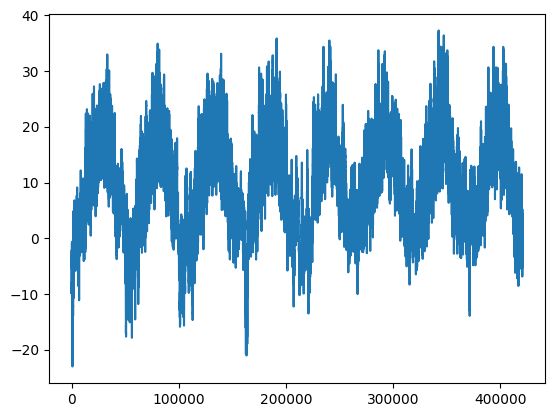

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(temperature)), temperature)

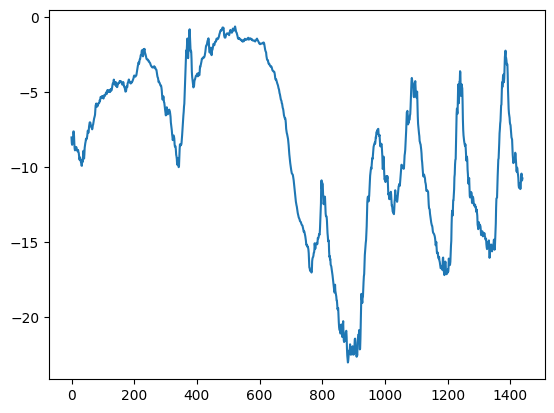

In [ ]:
plt.plot(range(1440), temperature[:1440])

In [ ]:
num_train_samples = int(0.5 * len(temperature))
num_val_samples   = int(0.25 * len(temperature))
num_test_samples  = len(temperature) - num_train_samples - num_val_samples

print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_val_samples}")
print(f"Number of testing samples: {num_test_samples}")

Number of training samples: 210225
Number of validation samples: 105112
Number of testing samples: 105114


In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

print(f"Raw data first sample after standardizations: \n{raw_data[0]}")

Raw data first sample after standardizations: 
[ 0.91365151 -1.92064015 -1.97449272 -1.86625827  1.04801712 -1.29131928
 -1.46715535 -0.78234525 -1.47012583 -1.4720352   2.12415558 -0.73016651
 -0.77935289 -0.28119316]


In [ ]:
from tensorflow import keras

sampling_rate   = 6
sequence_length = 120
delay           = sampling_rate * (sequence_length + 24 - 1)
batch_size      = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    data            = raw_data[:-delay],
    targets         = temperature[delay:],
    sampling_rate   = sampling_rate,
    sequence_length = sequence_length,
    shuffle         = True,
    batch_size      = batch_size,
    start_index     = 0,
    end_index       = num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data            = raw_data[:-delay],
    targets         = temperature[delay:],
    sampling_rate   = sampling_rate,
    sequence_length = sequence_length,
    shuffle         = True,
    batch_size      = batch_size,
    start_index     = num_train_samples,
    end_index       = num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data            = raw_data[:-delay],
    targets         = temperature[delay:],
    sampling_rate   = sampling_rate,
    sequence_length = sequence_length,
    shuffle         = True,
    batch_size      = batch_size,
    start_index     = num_train_samples + num_val_samples)

for samples, targets in train_dataset:
  print("Sample shape", samples.shape)
  print("Targets shape", targets.shape)
  break

Sample shape (256, 120, 14)
Targets shape (256,)


In [ ]:
def evaluate_naive_method(dataset):
  total_abs_err = 0
  samples_seen  = 0
  for samples, targets in dataset:
    preds          = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen  += samples.shape[0]
  return total_abs_err/samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [ ]:
# from tensorflow import keras
from tensorflow.keras import layers

# n_features = 14

inputs  = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x       = layers.GlobalAveragePooling1D()(inputs)
x       = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)
model   = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras" ,save_best_only=True)
]

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

history = model.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset,
          callbacks=callbacks)

model = keras.models.load_model('jena_dense.keras')
print(f"Test MAE {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - loss: 92.3587 - mae: 7.6438 - val_loss: 22.6358 - val_mae: 3.7450
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - loss: 22.7210 - mae: 3.8156 - val_loss: 20.9187 - val_mae: 3.6132
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 38s 46ms/step - loss: 21.9881 - mae: 3.7464 - val_loss: 20.8003 - val_mae: 3.6077
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - loss: 21.8865 - mae: 3.7357 - val_loss: 20.8977 - val_mae: 3.6225
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 55ms/step - loss: 21.7809 - mae: 3.7266 - val_loss: 20.7412 - val_mae: 3.5993
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - loss: 21.6496 - mae: 3.7157 - val_loss: 20.5883 - val_mae: 3.5800
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 21.5106 - mae: 3.7057 - val_loss: 20.5762 - val_mae: 3.5815
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 21.4362 - mae: 3.7004 - val_loss: 20.6634 - val_mae: 3.5966
Epoch 9/10
819/819 ━━━━━

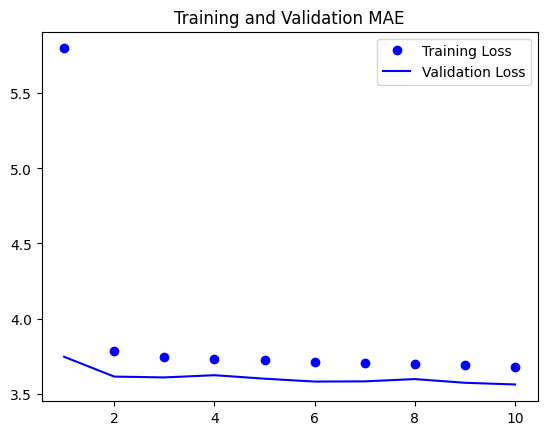

In [ ]:
loss     = history.history['mae']
val_loss = history.history['val_mae']
epochs   = range(1, len(loss) +1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

In [ ]:
inputs  = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x       = layers.Conv1D(8, 24, activation='relu')(inputs)
x       = layers.MaxPooling1D(2)(x)
x       = layers.Conv1D(8, 12, activation='relu')(x)
x       = layers.MaxPooling1D(2)(x)
x       = layers.Conv1D(8, 6, activation='relu')(x)
x       = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model   = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv1d.keras" ,save_best_only=True)
]

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

history = model.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset,
          callbacks=callbacks)

model = keras.models.load_model('jena_conv1d.keras')
print(f"Test MAE {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - loss: 30.4039 - mae: 4.2834 - val_loss: 17.3636 - val_mae: 3.3444
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - loss: 16.6230 - mae: 3.2400 - val_loss: 15.7059 - val_mae: 3.1281
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - loss: 14.8725 - mae: 3.0621 - val_loss: 13.4764 - val_mae: 2.8857
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 55ms/step - loss: 13.7871 - mae: 2.9471 - val_loss: 13.8588 - val_mae: 2.9419
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 13.0601 - mae: 2.8667 - val_loss: 14.5415 - val_mae: 3.0100
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 82s 56ms/step - loss: 12.5354 - mae: 2.8112 - val_loss: 13.2947 - val_mae: 2.8632
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - loss: 12.0674 - mae: 2.7589 - val_loss: 13.1619 - val_mae: 2.8444
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - loss: 11.6657 - mae: 2.7137 - val_loss: 12.8958 - val_mae: 2.8116
Epoch 9/10
819/819 ━━━━━

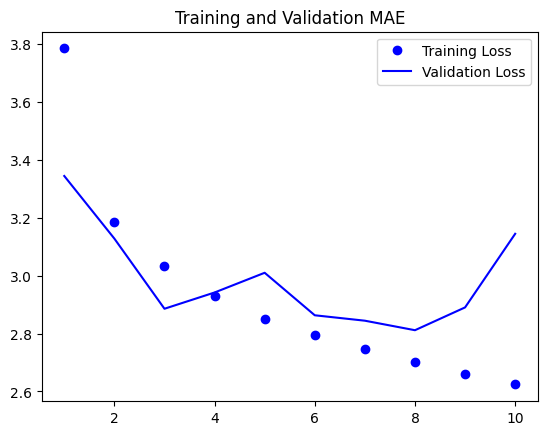

In [ ]:
loss     = history.history['mae']
val_loss = history.history['val_mae']
epochs   = range(1, len(loss) +1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

In [ ]:
inputs  = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x       = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model   = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv1d.keras" ,save_best_only=True)
]

model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

history = model.fit(train_dataset,
          epochs=10,
          validation_data=val_dataset,
          callbacks=callbacks)

model = keras.models.load_model('jena_conv1d.keras')
print(f"Test MAE {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 53s 63ms/step - loss: 74.4539 - mae: 6.5851 - val_loss: 12.4882 - val_mae: 2.6835
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 54ms/step - loss: 11.6260 - mae: 2.6368 - val_loss: 9.7924 - val_mae: 2.4310
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - loss: 9.8034 - mae: 2.4449 - val_loss: 9.5750 - val_mae: 2.4024
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 89s 60ms/step - loss: 9.3606 - mae: 2.3851 - val_loss: 9.7110 - val_mae: 2.4156
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - loss: 9.0537 - mae: 2.3425 - val_loss: 9.4860 - val_mae: 2.3940
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 83s 53ms/step - loss: 8.8089 - mae: 2.3098 - val_loss: 9.3228 - val_mae: 2.3753
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 8.5501 - mae: 2.2747 - val_loss: 9.3211 - val_mae: 2.3725
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - loss: 8.3294 - mae: 2.2475 - val_loss: 9.3865 - val_mae: 2.3761
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━━

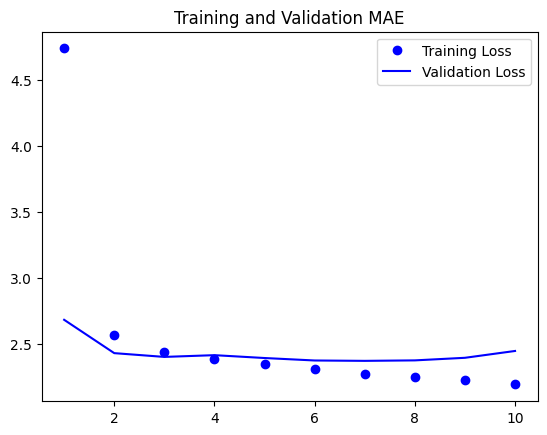

In [ ]:
loss     = history.history['mae']
val_loss = history.history['val_mae']
epochs   = range(1, len(loss) +1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

In [ ]:
state_t = 0
for input_t in input_seq:
  output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
  state_t = outout_t